<a href="https://colab.research.google.com/github/Manar-ibr/Segmentation-by-DL/blob/main/BacSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This cell to create a custom class and its support class to hold the configuration for notebook execution. This can be replaced by commandline parser of the python library, if executing it using commandline interperter . 

In [ ]:
import os
import random
from random import shuffle
import numpy as np
import torch
from torch.utils import data
from torchvision import transforms as T
from torchvision.transforms import functional as Fn
from PIL import Image,ImageOps
#map the dict to objects
class Map(dict):
    def __init__(self, *args, **kwargs):
        super(Map, self).__init__(*args, **kwargs)
        for arg in args:
            if isinstance(arg, dict):
                for k, v in arg.items():
                    self[k] = v

        if kwargs:
            for k, v in kwargs.items():
                self[k] = v

    def __getattr__(self, attr):
        return self.get(attr)

    def __setattr__(self, key, value):
        self.__setitem__(key, value)

    def __setitem__(self, key, value):
        super(Map, self).__setitem__(key, value)
        self.__dict__.update({key: value})

    def __delattr__(self, item):
        self.__delitem__(item)

    def __delitem__(self, key):
        super(Map, self).__delitem__(key)
        del self.__dict__[key]
#Parser class
class CustomParser(object):
    def __init__(self):
        self.config={}
    def add_argument(self,flag,type,default,help=None):
        key=flag.replace("--","")
        if type==float:
            value=float(default)
        if type==str:
            value=str(default)
        if type==int:
            value=int(default)
        self.config[key]=value
    def parse_args(self):
        return Map(self.config)

This cell can executed as follows and this is equivalent to the commadline parser class.

Install necessary libraries for executing the machine learning code. That include torch.

Download the 2016 dataset from the **internet** and unzip it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Download the Data and Groudtruth from the drive

In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

#file_id = '1kBwes2Adf8e5H-0ABuEBtfOicpm_fR2-'
#destination = 'data.zip'
#download_file_from_google_drive(file_id, destination)

In [ ]:
#file_id = '155CsiZDLVgX3AazIEiye5m6A5CPF4Yh5'
#destination = 'GT.zip'
#download_file_from_google_drive(file_id, destination)

In [ ]:
#to extract the data from zip file
import zipfile
pascal1category = zipfile.ZipFile('/content/drive/MyDrive/SampelData/BAC_Dataset_Data.zip', 'r')
pascal1category = pascal1category.extractall()
pascal3category = zipfile.ZipFile('/content/drive/MyDrive/SampelData/BAC_Dataset_GT.zip', 'r')
pascal3category = pascal3category.extractall()

In [ ]:
import zipfile
pascal1category = zipfile.ZipFile('/content/drive/MyDrive/dataset2.zip', 'r')
pascal1category = pascal1category.extractall()

In [ ]:
len(os.listdir("/content/New Folder With Items/test"))

Copy and prepare the dataset. We are splitting the datset into three sets - training,validation and test data. Create the necessary functions to split and copy. If we change dataset we need to change this code.

In [ ]:
import os
import argparse
import random
import shutil
from shutil import copyfile



#remove a directry
def rm_mkdir(dir_path):
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
        print('Remove path - %s'%dir_path)
    os.makedirs(dir_path)
    print('Create path - %s'%dir_path)

# split and copy the dataset, the argument is the config return by the parser
def split_and_copy(config):

    #if the traing,valid and test directories exists, remove it
    rm_mkdir(config.train_path)
    rm_mkdir(config.train_GT_path)
    rm_mkdir(config.valid_path)
    rm_mkdir(config.valid_GT_path)
    rm_mkdir(config.test_path)
    rm_mkdir(config.test_GT_path)
    rm_mkdir(config.model_path)
    filenames = os.listdir(config.origin_data_path)
    data_list = []
    GT_list = []

    #collect the filenames from the dataset source directories and calculate the poropotions according to
    # the configuration
    for filename in filenames:
        ext = os.path.splitext(filename)[-1]
        if ext =='.png':
            #filename = filename.split('.dcm')[0]
            data_list.append(filename)
            GT_list.append(filename)

    num_total = len(data_list)
    num_train = int((config.train_ratio/(config.train_ratio+config.valid_ratio+config.test_ratio))*num_total)
    num_valid = int((config.valid_ratio/(config.train_ratio+config.valid_ratio+config.test_ratio))*num_total)
    num_test = num_total - num_train - num_valid

    print('\nNum of train set : ',num_train)
    print('\nNum of valid set : ',num_valid)
    print('\nNum of test set : ',num_test)

    Arange = list(range(num_total))
    random.shuffle(Arange)

    for i in range(num_train):
        idx = Arange.pop()
        
        src = os.path.join(config.origin_data_path, data_list[idx])
        dst = os.path.join(config.train_path,data_list[idx])
        copyfile(src, dst)
        
        src = os.path.join(config.origin_GT_path, GT_list[idx])
        dst = os.path.join(config.train_GT_path, GT_list[idx])
        #2016 datset uses the name with Captial S in the word Segmentation
        dst=dst.replace("Segmentation","segmentation")
        copyfile(src, dst)
        
      

    for i in range(num_valid):
        idx = Arange.pop()

        src = os.path.join(config.origin_data_path, data_list[idx])
        dst = os.path.join(config.valid_path,data_list[idx])
        copyfile(src, dst)
        
        src = os.path.join(config.origin_GT_path, GT_list[idx])
        dst = os.path.join(config.valid_GT_path, GT_list[idx])
        #2016 datset uses the name with Captial S in the word Segmentation
        dst=dst.replace("Segmentation","segmentation")
        copyfile(src, dst)


    for i in range(num_test):
        idx = Arange.pop()

        src = os.path.join(config.origin_data_path, data_list[idx])
        dst = os.path.join(config.test_path,data_list[idx])
        copyfile(src, dst)
        
        src = os.path.join(config.origin_GT_path, GT_list[idx])
        dst = os.path.join(config.test_GT_path, GT_list[idx])
        #2016 datset uses the name with Captial S in the word Segmentation
        dst=dst.replace("Segmentation","segmentation")
        copyfile(src, dst)


Create the parser object for the configuration and call the split and copy funtion to prepare the dataset.

In [ ]:
parser=CustomParser()
# split ratios
parser.add_argument('--train_ratio', type=float, default=0.8)
parser.add_argument('--valid_ratio', type=float, default=0.1)
parser.add_argument('--test_ratio', type=float, default=0.1)
# data path
parser.add_argument('--origin_data_path', type=str, default='./BAC-Dataset-Data')
parser.add_argument('--origin_GT_path', type=str, default='./BAC-Dataset-GT')    
parser.add_argument('--train_path', type=str, default='./dataset/train/')
parser.add_argument('--train_GT_path', type=str, default='./dataset/train_GT/')
parser.add_argument('--valid_path', type=str, default='./dataset/valid/')
parser.add_argument('--valid_GT_path', type=str, default='./dataset/valid_GT/')
parser.add_argument('--test_path', type=str, default='./dataset/test/')
parser.add_argument('--test_GT_path', type=str, default='./dataset/test_GT/')
parser.add_argument('--model_path', type=str, default='./models/')

config = parser.parse_args()
split_and_copy(config)

To train the model we have to load the images to memory, but loading all images to the memory at the same time may causes the system RAM to fill to the maximum capacity. So write a custom loader class to load the images using a geneartor function. So the training function can load the images on demand. This class also apply a set of transformations to the images to increase the dataset size.

In [ ]:
# The same as orginal code file
import os
import random
from random import shuffle
import numpy as np
import torch
from torch.utils import data
from torchvision import transforms as T
from torchvision.transforms import functional as Fn
from PIL import Image,ImageOps

class ImageFolder(data.Dataset):
	def __init__(self, root,image_size=512,mode='train',augmentation_prob=0):
		"""Initializes image paths and preprocessing module list of input paths and a list of target paths.."""
		self.root = root
		
		# GT : Ground Truth
		self.GT_paths = root[:-1]+'_GT/'
		self.image_paths = list(map(lambda x: os.path.join(root, x), os.listdir(root)))
		self.image_size = image_size
		self.mode = mode
		self.RotationDegree = [0,90,180,270]
		self.augmentation_prob = augmentation_prob
		print("image count in {} path :{}".format(self.mode,len(self.image_paths))) # Print number of images

	def __getitem__(self, index):
		"""Reads an image from a file and preprocesses it and returns."""
		image_path = self.image_paths[index]
		filename = image_path.split('/')[-1]
		GT_path = self.GT_paths +  filename

		image = Image.open(image_path)
		image = image.resize((512,512))
  
		GT = Image.open(GT_path)
		GT = ImageOps.grayscale(GT)
		GT = GT.resize((512,512))
		#print(image.size,GT.size,image.mode,GT.mode)
		
                    
		#aspect_ratio = image.size[1]/image.size[0] # Ratio of image width to its height

		Transform = []
		train_tfms = []

		Transform.append(T.Resize((512,512))) #this is new from me to enable change batch size
		Transform.append(T.ToTensor())
		Transform = T.Compose(Transform)
		train_tfms = T.Compose([T.Resize((512,512)),
                                     T.ColorJitter(brightness=0.2, saturation=0.3, hue=0.25),
                                     T.ToTensor(),
                                     T.Normalize(0.2, 0.1)
                                    ])

		image = train_tfms(image)
		#image = Transform(image)
		GT = Transform(GT)
	   

		
		GT[GT > 0.5] = 1
		GT[GT <= 0.5] = 0
		#print(torch.max(GT))
		return image, GT

	def __len__(self):
		"""Returns the total number of font files."""
		return len(self.image_paths)

def get_loader(image_path, image_size, batch_size, num_workers=2, mode='train',augmentation_prob=0):
	"""Builds and returns Dataloader."""
	
	dataset = ImageFolder(root = image_path, image_size =image_size, mode=mode,augmentation_prob=augmentation_prob)
	data_loader = data.DataLoader(dataset=dataset,
								  batch_size=batch_size,
								  shuffle=True,
									pin_memory=True,
								  num_workers=num_workers)
	return data_loader

Run a test on the data_loader function. Convert image list to image to show dataset sample for image and binary segmentation. 

image count in train path :170


torch.Size([1, 1, 512, 512])
torch.Size([1, 3, 512, 512])


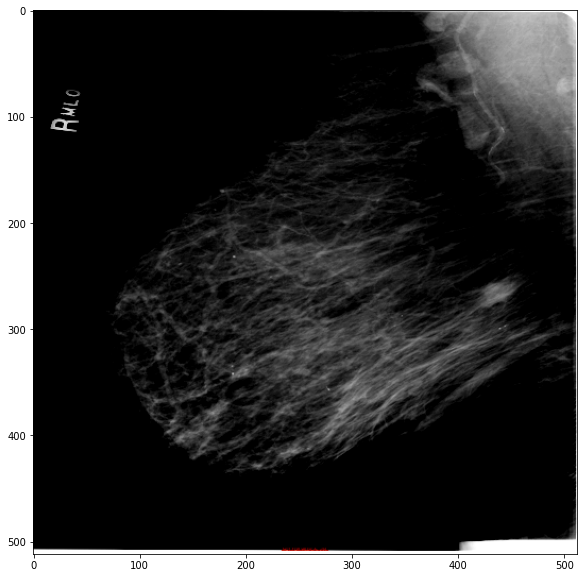

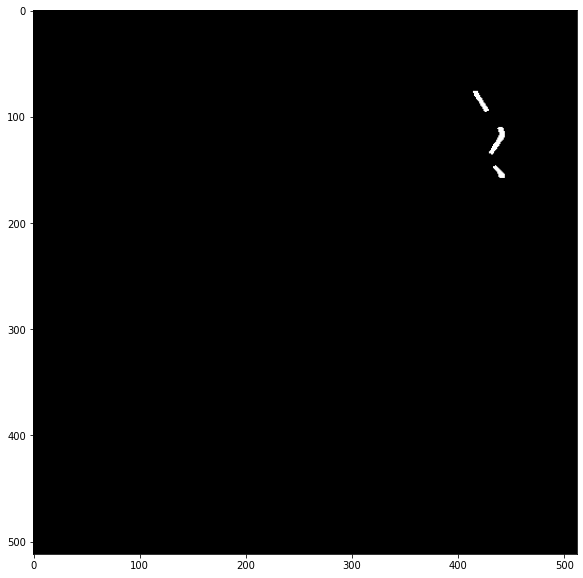

In [ ]:

from matplotlib import pyplot as plt

loader=get_loader('./dataset/train/',1,1,1)
for im,seg in loader: 
    break
print(seg.shape)
print(im.shape)

# Show Image
def show_image(image):
    # Convert image to numpy
    image = image.numpy()
    
    # Un-normalize the image
    #image[0] = image[0] * 0.226 + 0.445
    
    # Print the image
    fig = plt.figure(figsize=(25, 10))
    plt.imshow(np.transpose(image[0], (1, 2, 0)))

def show_image_T(image):
    fig = plt.figure(figsize=(25, 10))
    plt.imshow(torch.exp(image[0,0,:,:]).detach().cpu(), cmap="gray") 



#print(im.shape)
show_image(im)
show_image_T(seg)
#print (seg.shape)


def predict_image(image):
    image = image > 0
    image = image.byte()
    fig = plt.figure(figsize=(25, 10))
    plt.imshow(torch.exp(image[0,0,:,:]).detach().cpu(), cmap="gray")
    


Create a function to initalise the weights of the neural network. The weights are derived from a normal distribution.

Create convolutional block , up convolutional block and single convolutional block for the network and test it.

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)
class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x
class single_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(single_conv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x

conv_net=conv_block(10,10)
conv_net.apply(init_weights)
class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
       # nn.Dropout2d(0.5),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1

class RRCNN_block(nn.Module):

#Recurrent Residual Convolutional Neural Network Block

    def __init__(self, ch_in, ch_out, t=2):
        super(RRCNN_block, self).__init__()
        self.t = t
        self.RCNN = nn.Sequential(
        Recurrent_block(ch_out, t=t),
        Recurrent_block(ch_out, t=t)
    )
        self.Conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(ch_out),
            #nn.Dropout2d(0.5),
            nn.ReLU(inplace=True)
    )
        self.activate = nn.ReLU(inplace=True)
    # self.Conv = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        x1 = self.Conv(x)
        x2 = self.RCNN(x1)
        out = self.activate(x1 + x2)
        return out
class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi
       # new from another code 
class SpatialAttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttentionBlock, self).__init__()
        self.query = nn.Sequential(
            nn.Conv2d(in_channels,in_channels//8,kernel_size=(1,3), padding=(0,1)),
            nn.BatchNorm2d(in_channels//8),
            nn.ReLU(inplace=True)
        )
        self.key = nn.Sequential(
            nn.Conv2d(in_channels, in_channels//8, kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(in_channels//8),
            nn.ReLU(inplace=True)
        )
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        """
        :param x: input( BxCxHxW )
        :return: affinity value + x
        """
        B, C, H, W = x.size()
        # compress x: [B,C,H,W]-->[B,H*W,C], make a matrix transpose
        proj_query = self.query(x).view(B, -1, W * H).permute(0, 2, 1)
        proj_key = self.key(x).view(B, -1, W * H)
        affinity = torch.matmul(proj_query, proj_key)
        affinity = self.softmax(affinity)
        proj_value = self.value(x).view(B, -1, H * W)
        weights = torch.matmul(proj_value, affinity.permute(0, 2, 1))
        weights = weights.view(B, C, H, W)
        out = self.gamma * weights + x
        return out


class ChannelAttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(ChannelAttentionBlock, self).__init__()
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        """
        :param x: input( BxCxHxW )
        :return: affinity value + x
        """
        B, C, H, W = x.size()
        proj_query = x.view(B, C, -1)
        proj_key = x.view(B, C, -1).permute(0, 2, 1)
        affinity = torch.matmul(proj_query, proj_key)
        affinity_new = torch.max(affinity, -1, keepdim=True)[0].expand_as(affinity) - affinity
        affinity_new = self.softmax(affinity_new)
        proj_value = x.view(B, C, -1)
        weights = torch.matmul(affinity_new, proj_value)
        weights = weights.view(B, C, H, W)
        out = self.gamma * weights + x
        return out


class AffinityAttention(nn.Module):
    """ Affinity attention module """

    def __init__(self, in_channels):
        super(AffinityAttention, self).__init__()
        self.sab = SpatialAttentionBlock(in_channels)
        self.cab = ChannelAttentionBlock(in_channels)
        # self.conv1x1 = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)

    def forward(self, x):
        """
        sab: spatial attention block
        cab: channel attention block
        :param x: input tensor
        :return: sab + cab
        """
        sab = self.sab(x)
        cab = self.cab(x)
        out = sab #+ cab
        return out
    

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal


Create Recurrent block , RCNN block and  Attention block.

In [ ]:
# same 
class U_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1


In [ ]:

class R2U_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1,t=2):
        super(R2U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)
        
        self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)
        
        self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)
        
        self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)
        

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)
        
        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_RRCNN5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return d1


Create Recurrent Spatial Attention Network

In [ ]:
# spatial and chanel attention with classic u-net
class CSAttU_Net(nn.Module):
  
    def __init__(self,img_ch=3,output_ch=1):
        super(CSAttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        #here to put the new block
        self.affinity_attention = AffinityAttention(1024)
        self.attention_fuse = nn.Conv2d(1024 * 2, 1024, kernel_size=1)
        #
        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        input_feature = self.Conv5(x5)

         # Do Attenttion operations here
        attention = self.affinity_attention(input_feature)
        attention_fuse = input_feature + attention

        # decoding + concat path
        d5 = self.Up5(attention_fuse)
        d5 = torch.cat((x4,d5),dim=1)
        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1


In [ ]:

class RSCAU_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1,t=2):
        super(RSCAU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)
        #self.dropout = nn.Dropout(0.5)
        self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)
        
        self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)
        
        self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)
        
        self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)
        
        #here to put the new block
        self.affinity_attention = AffinityAttention(1024)
        self.attention_fuse = nn.Conv2d(1024 * 2, 1024, kernel_size=1)
        #
        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)
        
        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)
        #initialize_weights(self)

    def forward(self,x):
        # encoding path

        x1 = self.RRCNN1(x)
        #x1 = self.dropout(x1)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)
        #x2 = self.dropout(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)
        #x3 = self.dropout(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)
        #x4 = self.dropout(x4)

        x5 = self.Maxpool(x4)
        input_feature = self.RRCNN5(x5)

         # Do Attenttion operations here
        attention = self.affinity_attention(input_feature)

        attention_fuse = self.attention_fuse(torch.cat((input_feature, attention), dim=1))
        #attention_fuse = input_feature + attention
        
        # decoding + concat path
        d5 = self.Up5(attention_fuse)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_RRCNN5(d5)
        #d5 = self.dropout(d5)
        
        d4 = self.Up4(d5)
        
        d4 = torch.cat((x3,d4),dim=1)
        
        d4 = self.Up_RRCNN4(d4)
        #d4 = self.dropout(d4)

        d3 = self.Up3(d4)
        
        d3 = torch.cat((x2,d3),dim=1)
        
        d3 = self.Up_RRCNN3(d3)
        #d3 = self.dropout(d3)

        d2 = self.Up2(d3)
        
        d2 = torch.cat((x1,d2),dim=1)
        
        d2 = self.Up_RRCNN2(d2)
        #d2 = self.dropout(d2)

        d1 = self.Conv_1x1(d2)

        return d1


Create a set of functions to evaluate the models

In [ ]:
import torch
import torch.nn.functional as F


# SR : Segmentation Result
# GT : Ground Truth

def confusion(prediction, truth, threshold=0.5):
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """

    prediction = (prediction > threshold).type(torch.uint8)
    confusion_vector = prediction / truth
    truth1Pixels = torch.sum(truth == 1).item()
    truth0Pixels = torch.sum(truth == 0).item()
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)

    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()
    
    #if true_positives >= 0.9*truth1Pixels:
     # true_positives = truth1Pixels
     # false_negatives = 0
     # true_negatives = truth0Pixels
     # false_positives = 0
    return true_positives, false_positives, true_negatives, false_negatives


def get_accuracy(SR, GT, threshold=0):
    TP, FP, TN, FN = confusion(SR, GT)
    accuracy = float(TP + TN) / (float(TP + TN + FP + FN) + 1e-6)

    return accuracy
#def get_accuracy(SR,GT,threshold=0.5):
#    SR = SR > threshold
#    GT = GT == torch.max(GT)
#    corr = torch.sum(SR==GT)
#    tensor_size = SR.size(0)*SR.size(1)*SR.size(2)*SR.size(3)
#    acc = float(corr)/float(tensor_size)

    #return acc

def get_sensitivity(SR, GT, threshold=0):

    TP, FP, TN, FN = confusion(SR, GT)

    SE = float(TP) / (float(TP + FN) + 1e-6)

    return SE


def get_specificity(SR, GT, threshold=0):

    TP, FP, TN, FN = confusion(SR, GT)

    SP = float(TN) / (float(TN + FP) + 1e-6)
    return SP


def get_precision(SR, GT, threshold=0):
    TP, FP, TN, FN = confusion(SR, GT)
    PC = float(TP) / (float(TP + FP) + 1e-6)

    return PC


def get_F1(SR, GT, threshold=0):
    # Sensitivity == Recall
    SE = get_sensitivity(SR, GT, threshold=threshold)
    PC = get_precision(SR, GT, threshold=threshold)

    F1 = 2 * SE * PC / (SE + PC + 1e-6)

    return F1


def get_JS(SR, GT, threshold=0.5):
    #SR = (SR > threshold).type(torch.uint8)
    #Inter = torch.sum(((SR + GT) == 2).type(torch.uint8))
    #Union = torch.sum(((SR + GT) >= 1).type(torch.uint8))

    #JS = float(Inter) / (float(Union) + 1e-6)
    TP, FP, TN, FN = confusion(SR, GT)
    JS = float(TP) / (float(TP + FP + FN) + 1e-6)
    return JS


def get_DC(SR, GT, threshold=0.5):
    # DC : Dice Coefficient
    #SR = (SR > threshold).type(torch.uint8)
    TP, FP, TN, FN = confusion(SR, GT)
    DC = float(2 * TP) / (float(2*TP + FP + FN) + 1e-6)
    #Inter = torch.sum(((SR + GT) == 2).type(torch.uint8))
    #DC = float(2 * Inter) / (float(torch.sum(SR) + torch.sum(GT)) + 1e-6)

    return DC

Create a class that create the  models and feed the data. The class will create the requested model, train it, validate it and test it.

In [ ]:
#Focal loss https://amaarora.github.io/2020/06/29/FocalLoss.html
import torch
import torch.nn as nn
class WeightedFocalLoss(nn.Module):
    "Non weighted version of Focal Loss"
    def __init__(self, alpha=.25, gamma=2):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = torch.tensor([alpha, 1-alpha]).cuda()
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        targets = targets.type(torch.long)
        at = self.alpha.gather(0, targets.data.view(-1))
        pt = torch.exp(-BCE_loss)
        F_loss = at*(1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

In [ ]:
#IoULoss
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs .view(-1)
        targets = targets .view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [ ]:
#PyTorch
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [ ]:

#PyTorch
ALPHA = 0.8
GAMMA = 2

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(inputs.size(0),-1)
        targets = targets.view(targets.size(0),-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

In [ ]:
#PyTorch
ALPHA = 0.5
BETA = 0.5
GAMMA = 1
#after multiple epoch validation become all zero
class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky

In [ ]:
#PyTorch
class DiceBCEWithLogitsLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCEWithLogitsLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        loss = torch.nn.BCEWithLogitsLoss()
        BCEWithLogitsLoss = loss(inputs, targets)
        Dice_BCEWithLogitsLoss = BCEWithLogitsLoss + dice_loss
        
        return Dice_BCEWithLogitsLoss

In [ ]:
import os
import numpy as np
import time
import datetime
import torch
import torchvision
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
import time

import csv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Solver(object):
	def __init__(self, config, train_loader, valid_loader, test_loader):

		# Data loader
		self.train_loader = train_loader
		self.valid_loader = valid_loader
		self.test_loader = test_loader

		# Models
		self.unet = None
		self.optimizer = None
		self.img_ch = config.img_ch
		self.output_ch = config.output_ch
		pos_weight = torch.tensor([[9]]).to(device)
		self.criterion = torch.nn.BCEWithLogitsLoss()    #WeightedFocalLoss()#FocalLoss() #torch.nn.BCEWithLogitsLoss()  #torch.nn.BCELoss() #DiceCoeff() #FocalLoss2d()#FocalLoss()#WeightedFocalLoss() #IoULoss() #torch.nn.BCELoss() #nn.MSELoss().cuda()
		self.augmentation_prob = config.augmentation_prob

		# Hyper-parameters
		self.lr = config.lr
		self.beta1 = config.beta1
		self.beta2 = config.beta2

		# Training settings
		self.num_epochs = config.num_epochs
		self.num_epochs_decay = config.num_epochs_decay
		self.batch_size = config.batch_size

		# Step size
		self.log_step = config.log_step
		self.val_step = config.val_step

		# Path
		self.model_path = config.model_path
		self.result_path = config.result_path
		self.mode = config.mode

		self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
		self.model_type = config.model_type
		self.t = config.t
		self.build_model()
# I change this for more model
	def build_model(self):
		"""Build generator and discriminator."""
		if self.model_type =='U_Net':
			self.unet = U_Net(img_ch=3,output_ch=1)
		elif self.model_type =='R2U_Net':
			self.unet = R2U_Net(img_ch=3,output_ch=1,t=self.t)
		elif self.model_type =='AttU_Net':
			self.unet = AttU_Net(img_ch=3,output_ch=1)
		elif self.model_type == 'R2AttU_Net':
			self.unet = R2AttU_Net(img_ch=3,output_ch=1,t=self.t)
		elif self.model_type == 'RSCAU_Net':
			self.unet = RSCAU_Net(img_ch=3,output_ch=1,t=self.t)
		elif self.model_type == 'CSAttU_Net':
			self.unet = CSAttU_Net(img_ch=3,output_ch=1)
   
		self.optimizer = optim.Adam(list(self.unet.parameters()),
									  self.lr, [self.beta1, self.beta2])
		self.unet.to(self.device)

		# self.print_network(self.unet, self.model_type)

	def print_network(self, model, name):
		"""Print out the network information."""
		num_params = 0
		for p in model.parameters():
			num_params += p.numel()
		print(model)
		print(name)
		print("The number of parameters: {}".format(num_params))

	def to_data(self, x):
		"""Convert variable to tensor."""
		if torch.cuda.is_available():
			x = x.cpu()
		return x.data

	def update_lr(self, g_lr, d_lr):
		for param_group in self.optimizer.param_groups:
			param_group['lr'] = lr

	def reset_grad(self):
		"""Zero the gradient buffers."""
		self.unet.zero_grad()

	def compute_accuracy(self,SR,GT):
		SR_flat = SR.view(-1)
		GT_flat = GT.view(-1)

		acc = GT_flat.data.cpu()==(SR_flat.data.cpu()>0)

	def tensor2img(self,x):
		img = (x[:,0,:,:]>x[:,1,:,:]).float()
		img = img*255
		return img


	def train(self):
		"""Train encoder, generator and discriminator."""
	# new for plt
		#train_acc = []
		#train_losses = []
		#Val_acc = []
		#Val_losses = []
		#====================================== Training ===========================================#
		#===========================================================================================#
		#change this for test for one image
		unet_path = os.path.join(self.model_path, '%s.pkl' %(self.model_type))

		# U-Net Train
		if os.path.isfile(unet_path):
			with torch.no_grad():


    
    
			# Load the pretrained Encoder
				self.unet.load_state_dict(torch.load(unet_path))
   
				print('%s is Successfully Loaded from %s'%(self.model_type,unet_path))
   #	def test(self):      
				del self.unet
			#del best_unet
				self.build_model()
				self.unet.load_state_dict(torch.load(unet_path))
			
				self.unet.train(False)
				self.unet.eval()

				acc = 0.	# Accuracy
				SE = 0.		# Sensitivity (Recall)
				SP = 0.		# Specificity
				PC = 0. 	# Precision
				F1 = 0.		# F1 Score
				JS = 0.		# Jaccard Similarity
				DC = 0.		# Dice Coefficient
				length=0
				for i, (images, GT) in enumerate(self.test_loader):


					images = images.to(self.device) #to move from memory to GPU
					GT = GT.to(self.device)
					SR= self.unet(images)
					SR = torch.sigmoid(SR)
					#d2 = F.torch.sigmoid(d2)
					#d3 = F.torch.sigmoid(d3)
					#d4 = F.torch.sigmoid(d4)
					#d5 = F.torch.sigmoid(d5)
							 
				#SR = self.unet(images)
					acc += get_accuracy(SR,GT)
					SE += get_sensitivity(SR,GT)
					SP += get_specificity(SR,GT)
					PC += get_precision(SR,GT)
					F1 += get_F1(SR,GT)
					JS += get_JS(SR,GT)
					DC += get_DC(SR,GT)
				#show_image_T(images)
					#show_image_T(d2)
					#show_image_T(d3)
					#show_image_T(d4)
					#show_image_T(d5)
				#predict_image(SR)				 
        #for i=0 i< test_path.size
					torchvision.utils.save_image(images.data.cpu(),
											os.path.join(self.result_path,
														'%s_test_%d_image.png'%(self.model_type,i)))
					torchvision.utils.save_image(SR.data.cpu(),
											os.path.join(self.result_path,
														'%s_test_%d_SR.png'%(self.model_type,i)))
					torchvision.utils.save_image(GT.data.cpu(),
											os.path.join(self.result_path,
														'%s_test_%d_GT.png'%(self.model_type,i))) 
					length += images.size(0)
    
					
				acc = acc/length
				SE = SE/length
				SP = SP/length
				PC = PC/length
				F1 = F1/length
				JS = JS/length
				DC = DC/length
				unet_score = JS + DC
      
   
				f = open(os.path.join(self.result_path,'result.csv'), 'a', encoding='utf-8', newline='')
				wr = csv.writer(f)
				wr.writerow([self.model_type,acc,SE,SP,PC,F1,JS,DC])#lr,best_epoch
				f.close()
		else:
			# Train for Encoder
			lr = self.lr
			best_unet_score = 0.
			
			for epoch in range(self.num_epochs):

				self.unet.train(True)
				epoch_loss = 0
				
				acc = 0.	# Accuracy
				SE = 0.		# Sensitivity (Recall)
				SP = 0.		# Specificity
				PC = 0. 	# Precision
				F1 = 0.		# F1 Score
				JS = 0.		# Jaccard Similarity
				DC = 0.		# Dice Coefficient
				length = 0

				for i, (images, GT) in enumerate(self.train_loader):
					# GT : Ground Truth
					
					images = images.to(self.device)
					GT = GT.to(self.device)
					t0 = time.time()
					# SR : Segmentation Result
					SR = self.unet(images)        
					SR_probs = torch.sigmoid(SR) # To make probability between 0 and 1
					SR_flat = SR_probs.view(SR_probs.size(0),-1)
          
					GT_flat = GT.view(GT.size(0),-1)
		 #I change this
					loss = self.criterion(SR,GT)
					#loss = dice_loss(GT,SR)
					#loss2 = dice_coeff_loss(SR,GT)
					#loss = loss1 + loss2      
					epoch_loss += loss.item()

					# Backprop + optimize
					self.reset_grad()
					loss.backward()
					self.optimizer.step() # Update gradients 

					acc += get_accuracy(SR,GT)
					SE += get_sensitivity(SR,GT)
					SP += get_specificity(SR,GT)
					PC += get_precision(SR,GT)
					F1 += get_F1(SR,GT)
					JS += get_JS(SR,GT)
					DC += get_DC(SR,GT)
					length += images.size(0) #number of images
     



				
				acc = acc/length
				SE = SE/length
				SP = SP/length
				PC = PC/length
				F1 = F1/length
				JS = JS/length
				DC = DC/length
				epoch_loss= epoch_loss/length
        #for plt the list
				#train_acc.append(acc)
				#train_losses.append(epoch_loss)

        

				
				# Print the log info
				print('Epoch [%d/%d], Loss: %.10f, \n[Training] Acc: %.4f, SE: %.4f, SP: %.4f, PC: %.4f, F1: %.4f, JS: %.4f, DC: %.4f' % (
					  epoch+1, self.num_epochs, \
					  epoch_loss,\
					  acc,SE,SP,PC,F1,JS,DC),)
				print('{} seconds'.format(time.time()-t0))
				
				torchvision.utils.save_image(images.data.cpu(),
											os.path.join(self.result_path,
														'%s_train_%d_image.png'%(self.model_type,epoch+1)))
				torchvision.utils.save_image(SR.data.cpu(),
											os.path.join(self.result_path,
														'%s_train_%d_SR.png'%(self.model_type,epoch+1)))
				torchvision.utils.save_image(GT.data.cpu(),
											os.path.join(self.result_path,
														'%s_train_%d_GT.png'%(self.model_type,epoch+1)))
       
				torch.save(self.unet.state_dict(),unet_path)
        
        
			

				# Decay learning rate
				if (epoch+1) > (self.num_epochs - self.num_epochs_decay):
					lr -= (self.lr / float(self.num_epochs_decay))
					for param_group in self.optimizer.param_groups:
						param_group['lr'] = lr
					print ('Decay learning rate to lr: {}.'.format(lr))
				
				
				#===================================== Validation ====================================#
			
				self.unet.train(False)
				with torch.no_grad():

		
					self.unet.eval()
		
    #new compuote validation loss
					Val_loss = 0
					acc = 0.	# Accuracy
					SE = 0.		# Sensitivity (Recall)
					SP = 0.		# Specificity
					PC = 0. 	# Precision
					F1 = 0.		# F1 Score
					JS = 0.		# Jaccard Similarity
					DC = 0.		# Dice Coefficient
					length=0


					for i, (images, GT) in enumerate(self.valid_loader):

						t1 = time.time()
						images = images.to(self.device)
						GT = GT.to(self.device)
						SR = self.unet(images)
					#SR = self.unet(images)
     #same as in training to compuote the loss
						SR_probs = F.torch.sigmoid(SR) # To make probability between 0 and 1
						SR_flat = SR_probs.view(SR_probs.size(0),-1)
           
						GT_flat = GT.view(GT.size(0),-1)
						loss = self.criterion(SR,GT)       
						Val_loss += loss.item()
     

						acc += get_accuracy(SR,GT)
						SE += get_sensitivity(SR,GT)
						SP += get_specificity(SR,GT)
						PC += get_precision(SR,GT)
						F1 += get_F1(SR,GT)
						JS += get_JS(SR,GT)
						DC += get_DC(SR,GT)
						
						length += images.size(0)
					
					acc = acc/length
					SE = SE/length
					SP = SP/length
					PC = PC/length
					F1 = F1/length
					JS = JS/length
					DC = DC/length
					Val_loss = Val_loss/length
					unet_score = JS + DC

				#Val_acc.append(acc)
				#Val_losses.append(Val_loss)
					print('[Validation] Acc: %.4f,Loss: %.4f, SE: %.4f, SP: %.4f, PC: %.4f, F1: %.4f, JS: %.4f, DC: %.4f'%(acc,Val_loss,SE,SP,PC,F1,JS,DC))
					print('{} seconds'.format(time.time()-t1))
				
					torchvision.utils.save_image(images.data.cpu(),
											os.path.join(self.result_path,
														'%s_valid_%d_image.png'%(self.model_type,epoch+1)))
					torchvision.utils.save_image(SR.data.cpu(),
											os.path.join(self.result_path,
														'%s_valid_%d_SR.png'%(self.model_type,epoch+1)))
					torchvision.utils.save_image(GT.data.cpu(),
											os.path.join(self.result_path,
														'%s_valid_%d_GT.png'%(self.model_type,epoch+1)))
				


				 #Save Best U-Net model
					if unet_score >= best_unet_score:

						best_unet_score = unet_score
						best_epoch = epoch
					best_unet = self.unet.state_dict()
					print('Best %s model score : %.4f'%(self.model_type,best_unet_score))
					torch.save(best_unet,unet_path)
					
			#===================================== Test ====================================#
'''
	def test(self):      
			del self.unet
			del best_unet
			#self.build_model()
			self.unet.load_state_dict(torch.load(unet_path))
			
			self.unet.train(False)
			self.unet.eval()

			acc = 0.	# Accuracy
			SE = 0.		# Sensitivity (Recall)
			SP = 0.		# Specificity
			PC = 0. 	# Precision
			F1 = 0.		# F1 Score
			JS = 0.		# Jaccard Similarity
			DC = 0.		# Dice Coefficient
			length=0
			for i, (images, GT) in enumerate(self.test_loader):

				images = images.to(self.device) #to move from memory to GPU
				GT = GT.to(self.device)
				SR = F.torch.sigmoid(self.unet(images))
				#SR = self.unet(images)
				acc += get_accuracy(SR,GT)
				SE += get_sensitivity(SR,GT)
				SP += get_specificity(SR,GT)
				PC += get_precision(SR,GT)
				F1 += get_F1(SR,GT)
				JS += get_JS(SR,GT)
				DC += get_DC(SR,GT)
				#show_image_T(images)
				#show_image_T(GT)
				#predict_image(SR)				 
        #for i=0 i< test_path.size
				torchvision.utils.save_image(images.data.cpu(),
											os.path.join(self.result_path,
														'%s_test_%d_image.png'%(self.model_type,i)))
				torchvision.utils.save_image(SR.data.cpu(),
											os.path.join(self.result_path,
														'%s_test_%d_SR.png'%(self.model_type,i)))
				torchvision.utils.save_image(GT.data.cpu(),
											os.path.join(self.result_path,
														'%s_test_%d_GT.png'%(self.model_type,i))) 
				length += images.size(0)
    
					
			acc = acc/length
			SE = SE/length
			SP = SP/length
			PC = PC/length
			F1 = F1/length
			JS = JS/length
			DC = DC/length
			unet_score = JS + DC
      
   
			f = open(os.path.join(self.result_path,'result.csv'), 'a', encoding='utf-8', newline='')
			wr = csv.writer(f)
			wr.writerow([self.model_type,acc,SE,SP,PC,F1,JS,DC,self.lr,best_epoch,self.num_epochs,self.num_epochs_decay,self.augmentation_prob])#lr,best_epoch
			f.close()
			'''
			#show_image_T(images)
			#show_image_T(GT)
			#predict_image(SR)
			

	#		plt.figure(figsize=(10,5))
	#		plt.title("Training and validation Loss And Accuracy")
	#		plt.plot(train_acc,label="train_acc")
	#		plt.plot(train_losses,label="train_losses")
	#		plt.plot(Val_acc,label="Val_acc")
	#		plt.plot(Val_losses,label="Val_losses")
	#		plt.xlabel("Number of epoch")
	#		plt.ylabel("Loss and accuracy")
	#		plt.legend()
	#		plt.show()
   

			

Create a tarin and test function. It will take a config that include all deatils of the models and dataset information. Create the corresponding model, validate and test it.

In [ ]:
import os
from torch.backends import cudnn
import random


def train_and_test(config):
    cudnn.benchmark = True
    if config.model_type not in ['U_Net','R2U_Net','RSCAU_Net','CSAttU_Net']:
        print('ERROR!! model_type should be selected in U_Net/R2U_Net/RSCAU_Net/CSAttU_Net')
        print('Your input for model_type was %s'%config.model_type)
        return

    # Create directories if not exist
    if not os.path.exists(config.model_path):
        os.makedirs(config.model_path)
    if not os.path.exists(config.result_path):
        os.makedirs(config.result_path)
    config.result_path = os.path.join(config.result_path,config.model_type)
    if not os.path.exists(config.result_path):
        os.makedirs(config.result_path)
    
    #lr = random.random()*0.0005 + 0.0000005
    augmentation_prob= random.random()*0.7
    augmentation_prob= 0.4
    #epoch = random.choice([100,150,200,250])
    decay_ratio = random.random()*0.8
    decay_epoch = int(config.num_epochs*decay_ratio)

    config.augmentation_prob = augmentation_prob
    #config.num_epochs = epoch
    config.lr =  0.0001
    config.num_epochs_decay = decay_epoch

    print(config)
        
    train_loader = get_loader(image_path=config.train_path,
                            image_size=config.image_size,
                            batch_size=config.batch_size,
                            num_workers=config.num_workers,
                            mode='train',
                            augmentation_prob= config.augmentation_prob) #config.augmentation_prob
    valid_loader = get_loader(image_path=config.valid_path,
                            image_size=config.image_size,
                            batch_size=config.batch_size,
                            num_workers=config.num_workers,
                            mode='valid',
                            augmentation_prob=0.)
    test_loader = get_loader(image_path=config.test_path,
                            image_size=config.image_size,
                            batch_size=config.batch_size,
                            num_workers=config.num_workers,
                            mode='test',
                            augmentation_prob=0.)

    solver = Solver(config, train_loader, valid_loader, test_loader)

    
    # Train and sample the images
    if config.mode == 'train':
        solver.train()
    elif config.mode == 'test':
        solver.test()


In [ ]:
import os
from torch.backends import cudnn
import random

def train_and_test(config):
    cudnn.benchmark = True
    if config.model_type not in ['U_Net','R2U_Net','RSCAU_Net','CSAttU_Net']:
        print('ERROR!! model_type should be selected in U_Net/R2U_Net/RSCAU_Net/CSAttU_Net')
        print('Your input for model_type was %s'%config.model_type)
        return

    # Create directories if not exist
    if not os.path.exists(config.model_path):
        os.makedirs(config.model_path)
    if not os.path.exists(config.result_path):
        os.makedirs(config.result_path)
    config.result_path = os.path.join(config.result_path,config.model_type)
    if not os.path.exists(config.result_path):
        os.makedirs(config.result_path)
    
    lr = random.random()*0.0005 + 0.0000005
    augmentation_prob= random.random()*0.7
    #epoch = random.choice([100,150,200,250])
    decay_ratio = random.random()*0.8
    decay_epoch = int(config.num_epochs*decay_ratio)

    config.augmentation_prob = augmentation_prob
    #config.num_epochs = epoch
    config.lr = lr
    config.num_epochs_decay = decay_epoch

    print(config)
        
    train_loader = get_loader(image_path=config.train_path,
                            image_size=config.image_size,
                            batch_size=config.batch_size,
                            num_workers=config.num_workers,
                            mode='train',
                            augmentation_prob=config.augmentation_prob)
    valid_loader = get_loader(image_path=config.valid_path,
                            image_size=config.image_size,
                            batch_size=config.batch_size,
                            num_workers=config.num_workers,
                            mode='valid',
                            augmentation_prob=0.)
    test_loader = get_loader(image_path=config.test_path,
                            image_size=config.image_size,
                            batch_size=config.batch_size,
                            num_workers=config.num_workers,
                            mode='test',
                            augmentation_prob=0.)

    solver = Solver(config, train_loader, valid_loader, test_loader)

    
    # Train and sample the images
    if config.mode == 'train':
        solver.train()
    elif config.mode == 'test':
        solver.test()


Test the train and test function by feeding 2016 dataset

In [ ]:

parser = CustomParser()

    
# model hyper-parameters
parser.add_argument('--image_size', type=int, default=512)
parser.add_argument('--t', type=int, default=3, help='t for Recurrent step of R2U_Net or R2AttU_Net p')
    
# training hyper-parameters
parser.add_argument('--img_ch', type=int, default=3)
parser.add_argument('--output_ch', type=int, default=1)
parser.add_argument('--num_epochs', type=int, default=50)
parser.add_argument('--num_epochs_decay', type=int, default=7) #was 7
parser.add_argument('--batch_size', type=int, default=1)
parser.add_argument('--num_workers', type=int, default=2)
parser.add_argument('--lr', type=float, default=.0002 )
parser.add_argument('--beta1', type=float, default=0.5)        # momentum1 in Adam
parser.add_argument('--beta2', type=float, default=0.999)      # momentum2 in Adam    
parser.add_argument('--augmentation_prob', type=float, default=0.4)
parser.add_argument('--log_step', type=int, default=2)
parser.add_argument('--val_step', type=int, default=2)
# misc
parser.add_argument('--mode', type=str, default='train')
parser.add_argument('--model_type', type=str, default='RSCAU_Net', help='U_Net/R2U_Net/RSCAU_Net/CSAttU_Net')
parser.add_argument('--model_path', type=str, default='./models')
parser.add_argument('--train_path', type=str, default='./dataset/train/')
parser.add_argument('--valid_path', type=str, default='./dataset/valid/')
parser.add_argument('--test_path', type=str, default='./dataset/test/')
parser.add_argument('--result_path', type=str, default='./result/')
parser.add_argument('--cuda_idx', type=int, default=1)
config = parser.parse_args()
train_and_test(config)